<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li>&nbsp;&nbsp;</</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [2]:
#df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCreated', 'LastSeen', 'DateCrawled'])
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.describe(), df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


(         num_orders
 count  26496.000000
 mean      14.070463
 std        9.211330
 min        0.000000
 25%        8.000000
 50%       13.000000
 75%       19.000000
 max      119.000000,
 None)

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Пропусков нет, столбец datetime сделаем индексами и проведем ресемплирование по 1 часу

In [4]:
#
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

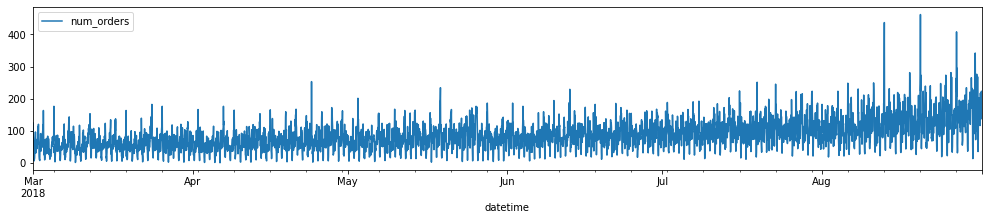

In [5]:
df.plot(figsize=(17, 3))

## Анализ

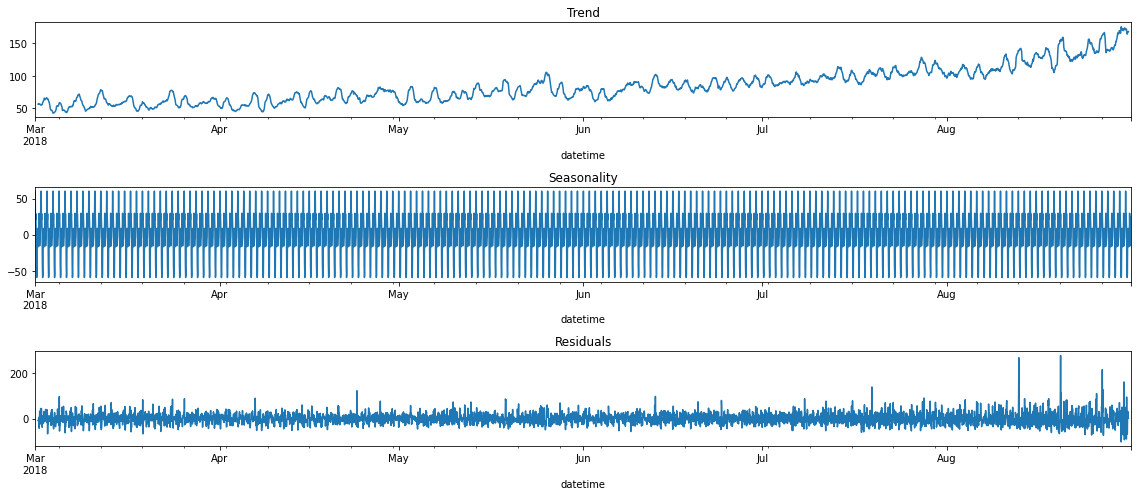

In [6]:
# проведем декомпозицию данных
decomposed = seasonal_decompose(df)
plt.figure(figsize=(16, 7))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Посмотрим на распределение заказов по часаv за неделю

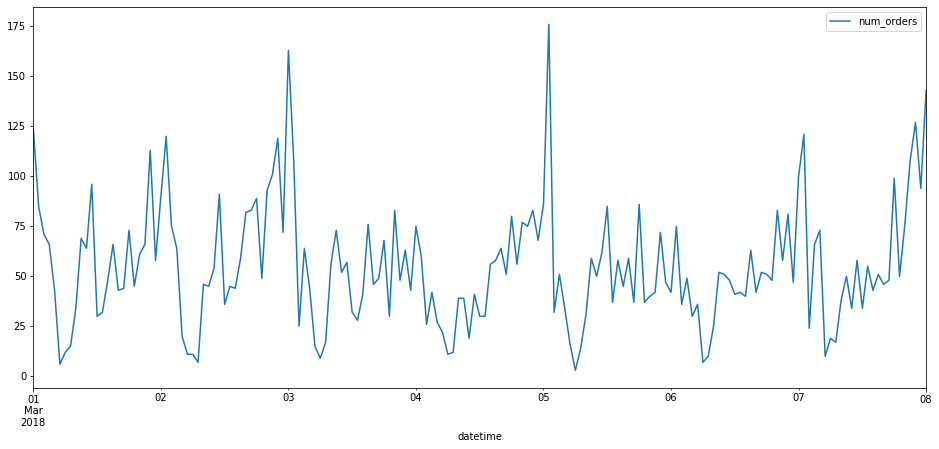

In [7]:
df['2018-03-01 00':'2018-03-08 00'].plot(figsize=(16, 7));

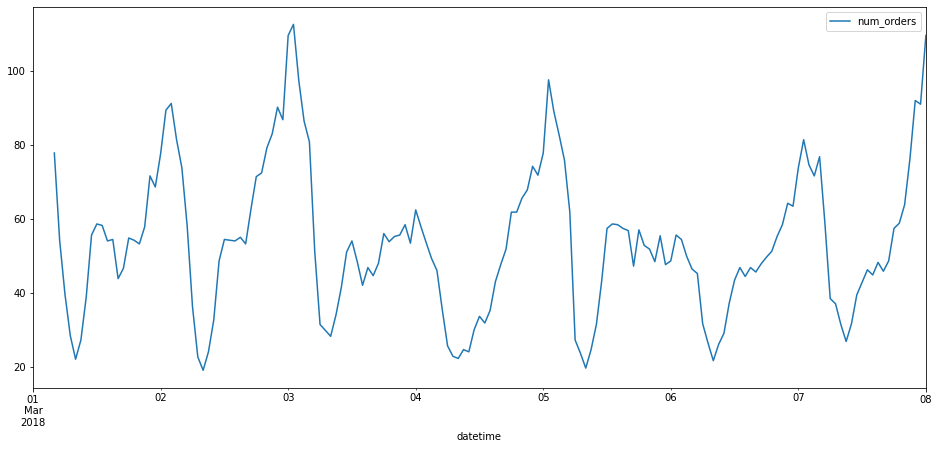

In [8]:
# отобразим скользящее среднее
df['2018-03-01 00':'2018-03-08 00'].rolling(5).mean().plot(figsize=(16, 7));

наблюдаем периодичность данных, проверим тренды и сезоны

Так мы видим:
* общее увеличение и падение количества заказов в зависимости от выходных и празднечных дней
* зависимость времени суток на количество заказов
* остаток декомпозиции от общего количества заказов которая не объясняется ни временем суток ни днем месяца или недели

## Обучение

In [9]:
# разделим данные на тренировочную и проверочную без перемешивания
train, test = train_test_split(df, shuffle=False, test_size=0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


попробуем спрогнозировать количество заказав на следующий час с помощью константы - среднего значения и оценим качество

In [10]:
print("Среднее количество заказов в час:", test['num_orders'].mean())

pred_median = np.ones(test.shape) * train['num_orders'].median()

print("Точность MAE:", mean_absolute_error(test, pred_median))

Среднее количество заказов в час: 139.55656108597285
Точность MAE: 70.7918552036199


попробуем спрогнозировать количество заказав на следующий час с помощью предыдущего значения и оценим качество

In [11]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("MAE:", mean_absolute_error(test,pred_previous))

MAE: 44.97285067873303


качество предсказаний по предыдущему значению лучше\
Для использования моделей нам необходимы признаки. Создадим свои признаки

In [12]:
def make_features(df, max_lag, rolling_mean_size):
    df1 = df.copy()
    df1['year'] = df1.index.year
    df1['month'] = df1.index.month
    df1['day'] = df1.index.day
    df1['dayofweek'] = df1.index.dayofweek
    df1['hour'] = df1.index.hour
    
    for lag in range(1, max_lag + 1):
        df1['lag_{}'.format(lag)] = df1['num_orders'].shift(lag)

    df1['rolling_mean'] = df1['num_orders'].shift().rolling(rolling_mean_size).mean()
    df1 = df1.dropna()
    return df1

df_filled = make_features(df, 4, 4)
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4412 entries, 2018-03-01 04:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4412 non-null   int64  
 1   year          4412 non-null   int64  
 2   month         4412 non-null   int64  
 3   day           4412 non-null   int64  
 4   dayofweek     4412 non-null   int64  
 5   hour          4412 non-null   int64  
 6   lag_1         4412 non-null   float64
 7   lag_2         4412 non-null   float64
 8   lag_3         4412 non-null   float64
 9   lag_4         4412 non-null   float64
 10  rolling_mean  4412 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 413.6 KB


In [13]:

df_filled.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,86.50
2018-03-01 05:00:00,6,2018,3,1,3,5,43.0,66.0,71.0,85.0,66.25
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,66.0,71.0,46.50
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,43.0,66.0,31.75
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,6.0,43.0,19.00


In [14]:
# разделим данные
def features_target(df):
    
    train, test = train_test_split(df, shuffle=False, test_size=0.1)
    train_features = train.drop(['num_orders'], axis=1)
    train_target = train['num_orders']
    test_features = test.drop(['num_orders'], axis=1)
    test_target = test['num_orders']
    return train_features, train_target, test_features, test_target


## Тестирование

Протестируем теорию на трех моделях `LinearRegression`, `import DecisionTreeRegressor`, `RandomForestRegressor`

In [15]:
# создадим функцию предсказания
def prediction(model, df_filled):
    
    train_features, train_target, test_features, test_target = features_target(df_filled)
    
    model.fit(train_features, train_target)
    train_predict = model.predict(train_features)
    test_predict = model.predict(test_features)
    
    return train_predict, test_predict

In [16]:
# LinearRegression
model=LinearRegression()
train_features, train_target, test_features, test_target = features_target(df_filled)
train_predict, test_predict = prediction(model, df_filled)
print("MAE тестовой выборки:", mean_absolute_error(test_target, test_predict))
print("RMSE тестовой выборки: ", mean_squared_error(test_target, test_predict, squared= False))

MAE тестовой выборки: 39.85220938462394
RMSE тестовой выборки:  52.57450685373692


In [17]:
# подбор количества параметров
tscv = TimeSeriesSplit()
max_lag = 0
max_rolling = 0
best_rmse = 100

for lag in range(1,7):
    for rolling in range(2, 22):
        df_filled = make_features(df, lag, rolling)
        
        rmse = []
        for train_index, test_index in tscv.split(df_filled):
            cv_train, cv_test = df_filled.iloc[train_index], df_filled.iloc[test_index]
            cv_train_features = cv_train.drop(['num_orders'], axis=1)
            cv_train_target = cv_train['num_orders']
            cv_test_features = cv_test.drop(['num_orders'], axis=1)
            cv_test_target = cv_test['num_orders']
    
            model=LinearRegression()
            model.fit(cv_train_features, cv_train_target)
    
            predictions = model.predict(cv_test_features)
    
            rmse.append(mean_squared_error(cv_test_target, predictions, squared= False))
    
        lst_rmse = np.average(rmse)
        
        if lst_rmse < best_rmse:
            best_rmse = lst_rmse
            max_lag = lag
            max_rolling = rolling
print("RMSE:", best_rmse, "max_lag:", max_lag, "max_rolling", max_rolling)

RMSE: 34.21220504558257 max_lag: 2 max_rolling 4


лучшее значение показателей max_lag: 2 max_rolling 4

In [18]:
# DecisionTreeRegressor
df_filled = make_features(df, 2, 4)
train_features, train_target, test_features, test_target = features_target(df_filled)
model = DecisionTreeRegressor()
train_predict, test_predict = prediction(model, df_filled)
print("RMSE:",mean_squared_error(test_target, test_predict, squared= False))

RMSE: 49.65386981223434


In [19]:
max_depth = 0
best_rmse = 100
cvs = -1000
for depth in range(1, 20):
    model_DTR = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    model_DTR.fit(train_features, train_target)
    test_predict = model_DTR.predict(test_features)
    score = cross_val_score(model_DTR, train_features, train_target, scoring = 'neg_root_mean_squared_error', cv=3).mean()
    
    if score > cvs:
        max_depth = depth
        cvs = score
        best_rmse = mean_squared_error(test_target, test_predict, squared= False)
print("Дерево решений с лучшей глубиной max_depth =", max_depth, "кроссвалидация модели: ", cvs)
print("RMSE:",best_rmse)

Дерево решений с лучшей глубиной max_depth = 7 кроссвалидация модели:  -30.7654702339611
RMSE: 54.04101171327328


лучшее количество деревьев для модели DecisionTreeRegressor = 7

In [20]:
# RandomForestRegressor
tscv = TimeSeriesSplit(n_splits=2)
for train, test in tscv.split(df_filled):
    print(train, test)
param_grid = {'max_depth': range(10, 22), 'n_estimators': range(10, 81, 10)}
model_RFR = RandomForestRegressor(random_state=12345)
my_cv = TimeSeriesSplit(n_splits=2)
search = GridSearchCV(estimator=model_RFR, param_grid=param_grid, cv=my_cv, scoring = 'neg_root_mean_squared_error')
search.fit(train_features, train_target)

print('Лучшее значение для случайного леса: {} при значениях гиперпараметров: {}'.format(-search.best_score_, search.best_params_))


[   0    1    2 ... 1469 1470 1471] [1472 1473 1474 ... 2939 2940 2941]
[   0    1    2 ... 2939 2940 2941] [2942 2943 2944 ... 4409 4410 4411]
Лучшее значение для случайного леса: 29.244048157797568 при значениях гиперпараметров: {'max_depth': 13, 'n_estimators': 70}


модель RandomForestRegressor показала лучшие результаты с параметрами: глубина дерева = 19 и количество деревьев = 70

In [21]:
model_RFR = RandomForestRegressor(max_depth=13, n_estimators=70, random_state=12345)
model_RFR.fit(train_features, train_target)
test_predict = model_RFR.predict(test_features)
print("RMSE:",mean_squared_error(test_target, test_predict, squared= False))

RMSE: 48.230610196808854


In [24]:
result=pd.DataFrame([{'Точночть':'50.1'}
                     , {'Точночть':'54.04'}
                     , {'Точночть':'47.23'}],
                    index=['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor'])
display(result)

,Точночть
LinearRegression,50.1
DecisionTreeRegressor,54.04
RandomForestRegressor,47.23


<AxesSubplot:xlabel='datetime'>

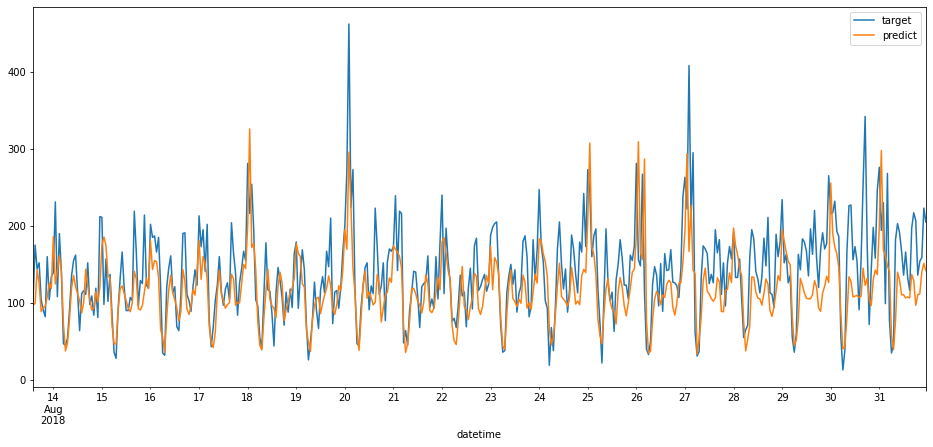

In [23]:
result=pd.DataFrame({'target':test_target, 'predict':test_predict})
result.plot(figsize=(16, 7))

**Вывод:**\
* исходные данные сгруппировали по часам и выяснили периодичность роста и спада количества заказов
* проверили возможность предсказания количества заказов без применения моделей и получили невысокие результаты
* для работы с моделями подготовили данные: дополнили их признаками даты и времени, а так же признаками предыдущих показателей
* выбрали лучшее количество этих показателей (дфп=3, rolling=10)
* обучили 3 модели `LinearRegression`, `DecisionTreeRegressor`, `RandomForestRegressor`
* проверили предсказания моделей с разными гиперпараметрами и выяснили что лучший результат показывает `RandomForestRegressor` с параметрами : глубина дерева = 19 и количество деревьев = 70
эту модель и предлагаем использовать для расчета предполагаемого количества заказов на следующий час.